In [1]:
import numpy as np
from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPModel, CyLPArray
import pandas as pd
import time
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [9]:
def var_matrix(n): # cette matrice calcule la différence de production d'énergie entre deux périodes consécutives
    M = np.zeros((n, n+1))
    for i in range(n):
        M[i,i] = -1
        M[i,i+1] = 1
    return np.matrix(M)


def matrix_sum_periods(N, T): # somme les productions d'énergie en périodes de T heures
    M = np.zeros((N//T, N))
    for i in range(N//T):
        M[i, i*T:(i+1)*T] = ([1] * T)
    
    return np.matrix(M)


def sum_by_col(matrix,N):
    sum_c = np.sum(np.array(matrix),axis = 0)
    sum_co = sum_c[:N]
    sum_co = CyLPArray(sum_co)
    return sum_co
    

def sum_rendement(rend, nb_site): # somme les rendements de chaque site sur toutes les heures / fonction objectif
    sum_rend = np.sum(rend, axis=1)
    c = np.ndarray((nb_site,))
    for i in range(nb_site):
        c[i] = sum_rend[i,0]
    c = CyLPArray(c)
    return c

def matrix_rendement(rend_off, rend_on, sites): # sélectionne les bonnes lignes des matrices de rendement
    lignes = len(rend_off)
    colonnes = len(rend_off[0])
    
    M = np.empty((lignes, colonnes))
    for i, site in sites.iterrows():
        if i < nb_site :
            if site['capacite offshore'] == 'Oui':
                M[i] = rend_off[i]
            else:
                M[i] = rend_on[i]
        
    return np.matrix(M)


def vecteur_OffouOn(sites, nb_site, N):
    M1 = np.zeros(nb_site)
    M2 = np.zeros(nb_site)
    idx = 0
    for i, site in sites.iterrows():
        if idx < nb_site:
            if site['capacite offshore'] == 'Oui':
                M1[idx] = cout_instal_offshore*(N/8760)
            else:
                M2[idx] = cout_instal_onshore*(N/8760)
            idx += 1
        
        
    return CyLPArray(M1 + M2)


def vector_to_matrix(vector,nb_site):
    A = np.zeros((nb_site,nb_site))
    np.fill_diagonal(A,vector)
    return A

In [3]:
# chargement des données pour tout le projet

nb_site = 642

sites = pd.read_csv('data/Sites.csv')
sites = sites.sort_values('index site')
sites = sites.reset_index()
capacites = sites['capacites'].copy()
capacites = CyLPArray(capacites)[:nb_site] # shape: (642,)


off_cap = sites['capacite offshore']
off_cap = off_cap.replace('Oui', 1)
off_cap = off_cap.replace('Non', 0)
off_cap = CyLPArray(off_cap)


rend_off_entire = np.genfromtxt('data/Rendements_offshore.csv', delimiter=',')
rend_on_entire = np.genfromtxt('data/Rendements_onshore.csv', delimiter=',')

#---------------------------------


# Consommation électrique (demande) par pays et par heure (matrice : ligne = pays, colonne = heure)
consommations_entire = np.genfromtxt('data/Consommations.csv', delimiter=',') # shape: (15, 8760)

# Couts d'installation amortis des éoliennes
cout_instal_onshore  = 168903 # Coût *amorti sur un an* pour l'installation d'un MW éolien on-shore (euros/MW/an)
cout_instal_offshore = 300336 # Coût *amorti sur un an* pour l'installation d'un MW éolien on-shore (euros/MW/an)
 
# Couts d'installation et de fonctionnement des centrales au gaz
cout_amorti_gaz = 94956 # Coût *amorti sur un an* pour l'installation d'un MW de centrale au gaz (euros/MW/an)
cout_fonct_gaz  = 65    # Coût de fonctionnement pour la production d'un MWh par centrale au gaz (euros/MWh)

## Données hydroélectriques 

# Stockage disponible par pays (en MWh)
stockage_hydro = np.array([0.3*1e6 , 3.2*1e6 , 0.01*1e6 , 0 , 18.4*1e6 , 9.8*1e6 , 0.24*1e6 , 7.9*1e6 , 0.005*1e6 , 84.147*1e6 , 0 , 2.6*1e6 , 1.2*1e6 , 33.756*1e6 , 8.4*1e6])

# Puissances maximales de turbinage et de pompage disponibles par pays (en MW)
p_turbinage = np.array([8587 , 12009 , 1417 , 9 , 18372 , 25132 , 527 , 21117 , 1140 , 28941 , 37 , 5052 , 4269 , 16637 , 15101])
p_pompage = np.array([5223 , 3580 , 1307 , 0 , 5347 , 4303 , 292 , 7544 , 1100 , 1396 , 0 , 1029 , 2744 , 45 , 1636 ])

eta_turbinage = 0.75 # Rendement pour le turbinage (sans unité)

# Apports naturels au stockagep par pays et par heure
apports_entire = np.genfromtxt('data/Apports-hydro.csv', delimiter=',') # shape: (15, 8760)

liste_pays = ['Allemagne','Autriche','Belgique','Danemark','Espagne','France','Irlande','Italie','Luxembourg',\
             'Norvège','Pays-Bas','Portugal','Royaume-Uni','Suède','Suisse']

## Situation II.1

In [4]:
def resolution_prob1(N,T, verbose = True):
    
    apports = apports_entire[:,:N] # shape: (15, N)
    consommations = consommations_entire[:,:N] # shape: (15, N)
    rend_off = rend_off_entire[:nb_site,:N] # shpae: (642, N)
    rend_on = rend_on_entire[:nb_site,:N] # shape: (642, N)
    M = stockage_hydro.sum() # scalar 
    P_p = p_pompage.sum() # scalar
    P_t = p_turbinage.sum() # scalar

    rend = matrix_rendement(rend_off, rend_on, sites) # shape: (642, N)
    I = np.matrix(np.eye(nb_site)) # shape: (642, 642)
    A = CyLPArray(matrix_sum_periods(N, T)@sum_by_col(apports,N))[0] # shape: (N/T,)
    D = CyLPArray(matrix_sum_periods(N, T)@sum_by_col(consommations, N))[0] # shape: (N/T,)
    R = np.matrix(matrix_sum_periods(N,T)@rend.T) # shape: (N/T, 642)
    
    
    # Variable
    model = CyLPModel()
    X   = model.addVariable('X', nb_site)
    B   = model.addVariable('B',N//T +1 )
    H_m = model.addVariable('H_m',N//T )
    H_d = model.addVariable('H_d',N//T)
    E   = model.addVariable('E',N//T )


    # Contraintes
    model.addConstraint(E + H_d >= D)
    model.addConstraint(R*X - E - H_m == 0)
    model.addConstraint(var_matrix(N//T)*B - H_m + np.matrix(np.eye(N//T)/eta_turbinage)*H_d == A)
    model.addConstraint(0 <= X <= capacites, 'capacitee')
    model.addConstraint(0 <= B <= M,'capa_stockage_hydro')
    model.addConstraint(0 <= H_m <= T*P_p)
    model.addConstraint(0 <= H_d <= T*P_t)
    model.addConstraint(B[0] == M/2,'capa_init_hydro')
    model.addConstraint(B[-1] == M/2,'capa_final_hydro')


    # Objectif
    C = vecteur_OffouOn(sites, nb_site, N)
    model.objective =  C * X

    s = CyClpSimplex(model)

    start = time.time()
    result = s.dual()
    end = time.time()

    if verbose:
        print("résolution:", result)

    return s, (end-start), D , A , R , M


In [38]:
N = 7*24
T = 3

print("N = {}\nT = {}\nNombre de site = {}\n".format(N, T,nb_site))

s , time_taken , D , A , R ,M  = resolution_prob1(N,T)
solHd = s.primalVariableSolution['H_d']
solE  = s.primalVariableSolution['E']
solB  = s.primalVariableSolution['B']
solX  = s.primalVariableSolution['X']
solHm = s.primalVariableSolution['H_m']

print("prix total de la production de l'énergie éléctrique : {:.2f} €".format(s.objectiveValue))
print("pourcentage de la production d'énergie qui vient des capacités hydroéléctrique : {:.2f} %".format(solHd.sum() *100 /(solHd.sum() + solE.sum())))
print("pourcentage de l'énergie produite par les éoliennes qui est convertie en énergie potentielle: {:.2f} %".format(solHm.sum()*100 /(solE.sum() + solHm.sum())))
print("prix moyen d'éléctricité consommée : {:.2f} €/MWh".format(s.objectiveValue/(D.sum())))
print("Temps de résolution: {:.0f} min {:.3f} sec".format(time_taken//60, time_taken % 60))





N = 168
T = 3
Nombre de site = 642

résolution: optimal
prix total de la production de l'énergie éléctrique : 2282760745.89 €
pourcentage de la production d'énergie qui vient des capacités hydroéléctrique : 9.67 %
pourcentage de l'énergie produite par les éoliennes qui est convertie en énergie potentielle: 3.07 %
prix moyen d'éléctricité consommée : 41.63 €/MWh
Temps de résolution: 0 min 0.012 sec


## Analyse post-optimale ##

Regardons maintenant combien rapporterait l'installation d'un MWh supplémentaire de stockage.
Pour cela nous allons regarder les variables du problème dual associées aux contraintes du problème primal qui sont impactées par un changement de la capacité de stockage hydroéléctriques.
Il y a trois contraintes du problème primal qui varie lorsque la capacité de sotckage augmente. Ce sont les contraintes 'capa_stockage_hydro' , 'capa_init_hydro' , 'capa_final_hydro'.

In [6]:
# vérification des contraintes

#1

test_capacites = True
for i in range(len(capacites)):
    if solX[i] - capacites[i] > 1e-5:
        test_capacites = False
        print('ERREUR: indice {}, {} > {}'.format(i, solX[i], capacites[i]))
if test_capacites:
    print('test capacites: OK')
    
# 2

solBVar = np.array(var_matrix(N//T)@solB)[0]
test_diffB = True
for i in range(len(solBVar)):
    if abs(solBVar[i] - (A[i] + solHm[i] - solHd[i]/eta_turbinage)) > 1e-5:
        test_diffB = False
        print('ERREUR: {} != {} + {} - {}/eta'.format(solBVar[i], A[i], solHm[i], solHd[i]))
if test_diffB:
    print('test différence barrage: OK')

# 3

test_demande = True
for i in range(len(solE)):
    if D[i] - solE[i] - solHd[i] > 1e-5:
        test_demande = False
        print('ERREUR: indice {}, demande: {}, dispo: {} + {} = {}'.format(i, D[i], solE[i], solHd[i], solE[i] + solHd[i]))
if test_demande:
    print('test demande: OK')

# 4

test_production = True
for i in range(len(solE)):
    if abs( np.array(R@solX)[0][i] - solE[i] - solHm[i] ) > 1e-5:
        test_production = False
        print('ERREUR')
if test_production:
    print('test production: OK')

test capacites: OK
test différence barrage: OK
test demande: OK
test production: OK


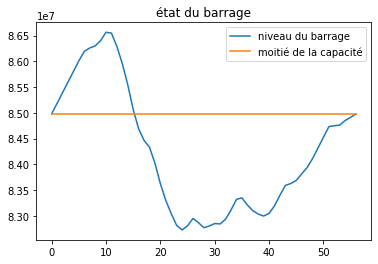

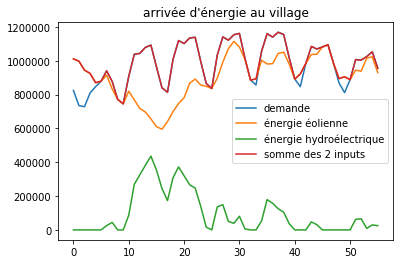

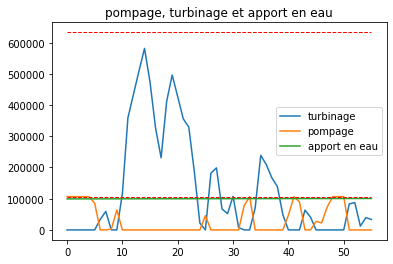

In [317]:
# quelques plots pour tester

plt.plot(solB)
plt.plot([M/2]*len(solB))
plt.title('état du barrage')
plt.legend(['niveau du barrage', 'moitié de la capacité'])
plt.show()

plt.plot(D)
plt.plot(solE)
plt.plot(solHd)
plt.plot(solE+solHd)
plt.title('arrivée d\'énergie au village')
plt.legend(['demande', 'énergie éolienne', 'énergie hydroélectrique', 'somme des 2 inputs'])
plt.show()

plt.plot(solHd/eta_turbinage)
plt.plot(solHm)
plt.plot(A)
plt.plot([106638] * len(A), '--r', linewidth=1)
plt.plot([633388] * len(A), '--r', linewidth=1)
plt.title('pompage, turbinage et apport en eau')
plt.legend(['turbinage', 'pompage', 'apport en eau'])
plt.show()

In [318]:
# vérification que apport en eau + pompage = turbinage

tot = A.sum() + solHm.sum() - (solHd/eta_turbinage).sum()
print('doit être tres petit:', tot)
print(T*P_p, T*P_t/eta_turbinage)
print(P_p, P_t)

doit être tres petit: -5.587935447692871e-09
106638 633388.0
35546 158347


## Situation II.2

In [23]:
def resolution_prob2(N,T):
    
    
    apports = apports_entire[:,:N] # shape: (15, N)
    consommations = consommations_entire[:,:N] # shape: (15, N)
    rend_off = rend_off_entire[:,:N] # shpae: (642, N)
    rend_on = rend_on_entire[:,:N] # shape: (642, N)
    M = stockage_hydro.sum() # scalar 
    P_p = p_pompage.sum() # scalar
    P_t = p_turbinage.sum() # scalar

    rend = matrix_rendement(rend_off, rend_on, sites) # shape: (642, N)
    I = np.matrix(np.eye(nb_site)) # shape: (642, 642)
    A = CyLPArray(matrix_sum_periods(N, T)@sum_by_col(apports,N))[0] # shape: (N/T,)
    D = CyLPArray(matrix_sum_periods(N, T)@sum_by_col(consommations, N))[0] # shape: (N/T,)
    R = np.matrix(matrix_sum_periods(N,T)@rend.T) # shape: (N/T, 642)
    
    half_capacites = capacites / 2
    matrix_capa = vector_to_matrix(half_capacites,nb_site)
    
    
    # Variables
    model = CyLPModel()
    X   = model.addVariable('X', nb_site)
    B   = model.addVariable('B',N//T +1 )
    H_m = model.addVariable('H_m',N//T )
    H_d = model.addVariable('H_d',N//T)
    E   = model.addVariable('E',N//T )


    # Contraintes
    model.addConstraint(E + H_d >= D)
    model.addConstraint(var_matrix(N//T)*B - H_m + np.matrix(np.eye(N//T)/eta_turbinage)*H_d == A)
    model.addConstraint(0 <= B <= M)
    model.addConstraint(0 <= H_m <= T*P_p)
    model.addConstraint(0 <= H_d <= T*P_t)
    model.addConstraint(B[0] == M/2)
    model.addConstraint(B[-1] == M/2)
    model.addConstraint(0 <= X <= 2)
    model.addConstraint((R@matrix_capa)*X - E - H_m ==0)
    
    
    # Objectif
    C = vecteur_OffouOn(sites, nb_site, N)
    O = C @ matrix_capa
    model.objective = O*X
    
    
    
    s = CyClpSimplex(model)
    s.setInteger(X)
    cbcModel = s.getCbcModel()
    start = time.time()
    cbcModel.branchAndBound()
    
    end = time.time()
    

    
    return cbcModel , (end-start) , D
    
    


In [39]:
N = 7*24
T = 3

print("N = {}\nT = {}\nNombre de site = {}\n".format(N, T,nb_site))

s2 , time_taken , D2  = resolution_prob2(N,T)
solHd2 = s2.primalVariableSolution['H_d']
solE2  = s2.primalVariableSolution['E']
solB2  = s2.primalVariableSolution['B']
solX2  = s2.primalVariableSolution['X']
solHm2 = s2.primalVariableSolution['H_m']

print("prix total de la production de l'énergie éléctrique : {:.2f} €".format(s2.objectiveValue))
print("pourcentage de la production d'énergie qui vient des capacités hydroéléctrique : {:.2f} %".format(solHd2.sum() *100 /(solHd2.sum() + solE2.sum())))
print("pourcentage de l'énergie produite par les éoliennes qui est convertie en énergie potentielle: {:.2f} %".format(solHm2.sum()*100 /(solE2.sum() + solHm2.sum())))
print("prix moyen d'éléctricité consommée : {:.2f} €/MWh".format(s2.objectiveValue/(D2.sum())))
print("Temps de résolution: {:.0f} min {:.3f} sec".format(time_taken//60, time_taken % 60))



N = 168
T = 3
Nombre de site = 642

prix total de la production de l'énergie éléctrique : 2282789266.00 €
pourcentage de la production d'énergie qui vient des capacités hydroéléctrique : 9.68 %
pourcentage de l'énergie produite par les éoliennes qui est convertie en énergie potentielle: 3.08 %
prix moyen d'éléctricité consommée : 41.63 €/MWh
Temps de résolution: 0 min 17.178 sec


### Graphe du temps d'éxecution en fonction du nombre d'heures considérées ###


In [35]:
N = 2500


temps_exec_prob1 = []
temps_exec_prob2 = []
N_vector = np.array([(i+1)*N//7 for i in range(7)])
    

for N_ in N_vector:    
    temps_exec_prob1.append(resolution_prob1(N_, T,verbose=False)[1])

for N_ in N_vector[:4]:    
    temps_exec_prob2.append(resolution_prob2(N_, T)[1])
    

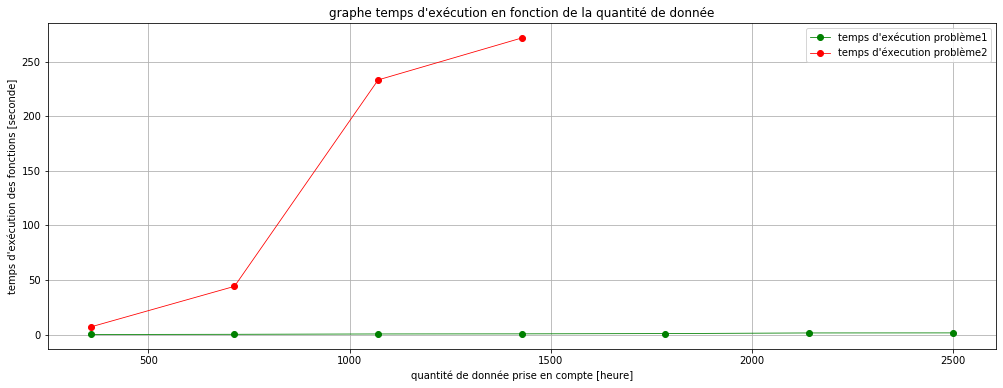

In [36]:
plt.figure(figsize=(17,6))
plt.plot(N_vector, temps_exec_prob1, '-og', linewidth=0.8)
plt.plot(N_vector[:4], temps_exec_prob2, '-or', linewidth=0.8)
plt.xlabel('quantité de donnée prise en compte [heure]')
plt.ylabel('temps d\'exécution des fonctions [seconde]')
plt.title('graphe temps d\'exécution en fonction de la quantité de donnée')
plt.grid()
plt.legend(['temps d\'exécution problème1', 'temps d\'éxecution problème2'])
plt.show()

## Situation III ###

In [216]:
# Paramètres
N = 24*7
T = 3

# Constantes
apports = apports_entire[:,:N] # shape: (15, N)
consommations = consommations_entire[:,:N] # shape: (15, N)
rend_off = rend_off_entire[:,:N] # shpae: (642, N)
rend_on = rend_on_entire[:,:N] # shape: (642, N)
rend = matrix_rendement(rend_off, rend_on, sites) # shape: (642, N)

for i, pays in enumerate(liste_pays):
    sites_pays = sites[sites['pays'] == pays]
    apports_pays = apports[i]
    consommations_pays = consommations[i]
    nb_sites_pays = len(sites_pays)
    capacites_pays = sites[sites['pays']==pays]['capacites']
    
    rend_pays = np.matrix(np.empty((nb_sites_pays, N))) # shape: (nb_sites_pays, N)
    for idx, j in enumerate(np.array(sites_pays['index site'])):
        rend_pays[idx] = np.array(rend)[j]
    
    M = stockage_hydro[i]
    P_p = p_pompage[i]
    P_t = p_turbinage[i]
    
    I = np.matrix(np.eye(nb_sites_pays))
    A = CyLPArray(matrix_sum_periods(N, T)@apports_pays)[0]
    D = CyLPArray(matrix_sum_periods(N, T)@consommations_pays)[0]
    R = np.matrix(matrix_sum_periods(N,T)@rend_pays.T)
    
    model = CyLPModel()
    X   = model.addVariable('X', nb_sites_pays)
    B   = model.addVariable('B', N//T +1 )
    H_m = model.addVariable('H_m', N//T )
    H_d = model.addVariable('H_d', N//T)
    E   = model.addVariable('E', N//T )


    # Contraintes
    model.addConstraint(E + H_d >= D)
    if R.shape[1] == 1:
        model.addConstraint(X*R - E - H_m == 0)
    else:
        model.addConstraint(R*X - E - H_m == 0)
    model.addConstraint(var_matrix(N//T)*B - H_m + np.matrix(np.eye(N//T)/eta_turbinage)*H_d == A)

    model.addConstraint(0 <= X <= capacites_pays, 'capacitee')
    model.addConstraint(0 <= B <= M)
    model.addConstraint(0 <= H_m <= T*P_p)
    model.addConstraint(0 <= H_d <= T*P_t)

    model.addConstraint(B[0] == M/2)
    model.addConstraint(B[-1] == M/2)


    # Objectif
    C = vecteur_OffouOn(sites_pays, nb_sites_pays, N)
    model.objective =  C * X


    #print('création du simplex...', end='')
    s = CyClpSimplex(model)
    #print('done')

    print(s.dual())
    #print('solution:', s.objectiveValue)

primal infeasible
primal infeasible
primal infeasible
optimal
optimal
optimal
optimal
optimal
primal infeasible
optimal
primal infeasible
optimal
primal infeasible
optimal
optimal
